# Getting x-coordinate of Lip Landmark

In [1]:
import cv2
import mediapipe as mp
import numpy as np

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh

#파일 위치 미리 지정
input_video_path = "S#17 C#3 촬영본.mp4"
save_video_path = 'S#17 C#3 촬영본_output.mp4'

cap = cv2.VideoCapture(input_video_path)

#재생할 파일의 넓이와 높이
width = cap.get(cv2.CAP_PROP_FRAME_WIDTH)
height = cap.get(cv2.CAP_PROP_FRAME_HEIGHT)
#video controller
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(save_video_path, fourcc, 30, (int(width), int(height)))
position = []

with mp_face_mesh.FaceMesh(min_detection_confidence = 0.5) as face_mesh:
    while cap.isOpened():
        success, image = cap.read()
        if not success:
            break
        
        # 필요에 따라 성능 향상을 위해 이미지 작성을 불가능함으로 기본 설정합니다.
        image.flags.writeable = False
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image)
        
        # 포즈 주석을 이미지 위에 그립니다.
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        frame_vector_x = []
        
        if results.multi_face_landmarks:            
            for idx, point in enumerate(results.multi_face_landmarks[0].landmark):
                height, width, _ = image.shape
                # point.x, point.y => relative values.
                # cx, cy => x, y coordinates for drawing lip landmarks on the video
                cx, cy = int(point.x * width), int(point.y * height)
                if idx in [0, 11, 12, 13, 14, 15, 16, 17]: # lip landmarks indices
                    frame_vector_x.append(point.x)
                    cv2.circle(image, (cx, cy), 3, (0,255,0), -1) 
                    
            # 입술 점들의 x값들의 평균을 내어 1개의 값으로 저장. 
            my_array = np.array(frame_vector_x)
            position.append(my_array.mean())
        else:
            # 점이 보이지 않을 때는 값을 0으로 지정
            position.append(0)
                

        cv2.imshow('Face Mesh', image)
        out.write(image)
        if cv2.waitKey(1) & 0xFF == 27:  # 'Esc' 키를 누르면 종료
            break

# 정리 작업
cap.release()
out.release()
cv2.destroyAllWindows()

2023-12-09 23:39:40.342282: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


# position 값 조정

1초 = 30프레임마다 값을 가져옴. 

len(position) = 30 * 44.5(초) = 1335

len(audio) = 4238 (4.238초)


=> 후시녹음의 시간과 영상에 나오는 시간에 알맞게 position의 값들을 자르고, 늘리고, 조금씩 보정해서 아래 음향보정의 coordinates 값으로 지정. 

<보정 방안> 
- 후시녹음의 초반 공백까지 고려했을 때 말하는 시기의 입술의 움직임을 포함하고 있는 구간은 26~30초.
- 26초에 해당되는 780프레임부터 후시녹음의 길이(4.2초)만큼 더한 906프레임까지의 값을 가져옴.
- pydub library에서는 오디오 파일의 프레임 계산은 1초 = 1000프레임. 후시녹음의 프레임은 총 4238개.
- position 리스트의 값마다 33번 반복한 후(30프레임 * 33번 = 990개로 늘이기) 앞 뒤로 0의 값을 앞 뒤로 40번씩 추가해서 위치 값도 마찬가지로 4238개가 되도록 조정. 

In [3]:
from pydub import AudioSegment
from pydub.playback import play

audio = AudioSegment.from_file("S#17 C#3 후시녹음.wav")
len(audio)

4238

In [2]:
len(position)

1335

In [6]:
# 배우가 말하는 시간대의 입술 위치
sound_position = position[780:906]

# pydub 라이브러리 적용을 위한 리스트 값 보정
actual_sound_position =[]
for i in sound_position:
    for j in range(33):
        actual_sound_position.append(i)

print('값을 반복한 이후 리스트의 길이: ', len(actual_sound_position))
for i in range(40):
    actual_sound_position.insert(0,0)
    actual_sound_position.append(0)
    
print('최종 보정된 리스트의 길이: ', len(actual_sound_position))

값을 반복한 이후 리스트의 길이:  4158
최종 보정된 리스트의 길이:  4238


# 음향 보정

In [17]:
from pydub import AudioSegment
from pydub.playback import play


def adjust_sound_by_coordinates(input_file, output_file, coordinates):
    # 오디오 파일 읽기
    audio = AudioSegment.from_file(input_file)

    # 좌표 값에 따라 왼쪽과 오른쪽 사운드를 조절
    for i in range(len(audio)):
        # x 좌표 값과 프레임 위치에 따라 조절값 계산
        # 가운데인 0.5를 기준으로 왼쪽에 있으면 adjustment는 음수, 오른쪽에 있으면 양수.
        x_coordinate = coordinates[i]
        adjustment = (x_coordinate - 0.5)    

        left_channel = audio[i].split_to_mono()[0] - adjustment 
        right_channel = audio[i].split_to_mono()[1] + adjustment

        # 왼쪽과 오른쪽 채널을 다시 합치기
        modified_audio = AudioSegment.from_mono_audiosegments(left_channel, right_channel)

        # 조절된 오디오를 원래 위치에 덮어쓰기
        audio = audio.overlay(modified_audio, position=i)

    # 조절된 오디오를 새로운 파일로 내보내기
    audio.export(output_file, format="wav")

# 사용 예시
input_file = "S#17 C#3 후시녹음.wav"
output_file = "S#17 C#3 후시녹음_output_audio_coordinates.wav"
coordinates = actual_sound_position 
adjust_sound_by_coordinates(input_file, output_file, coordinates)

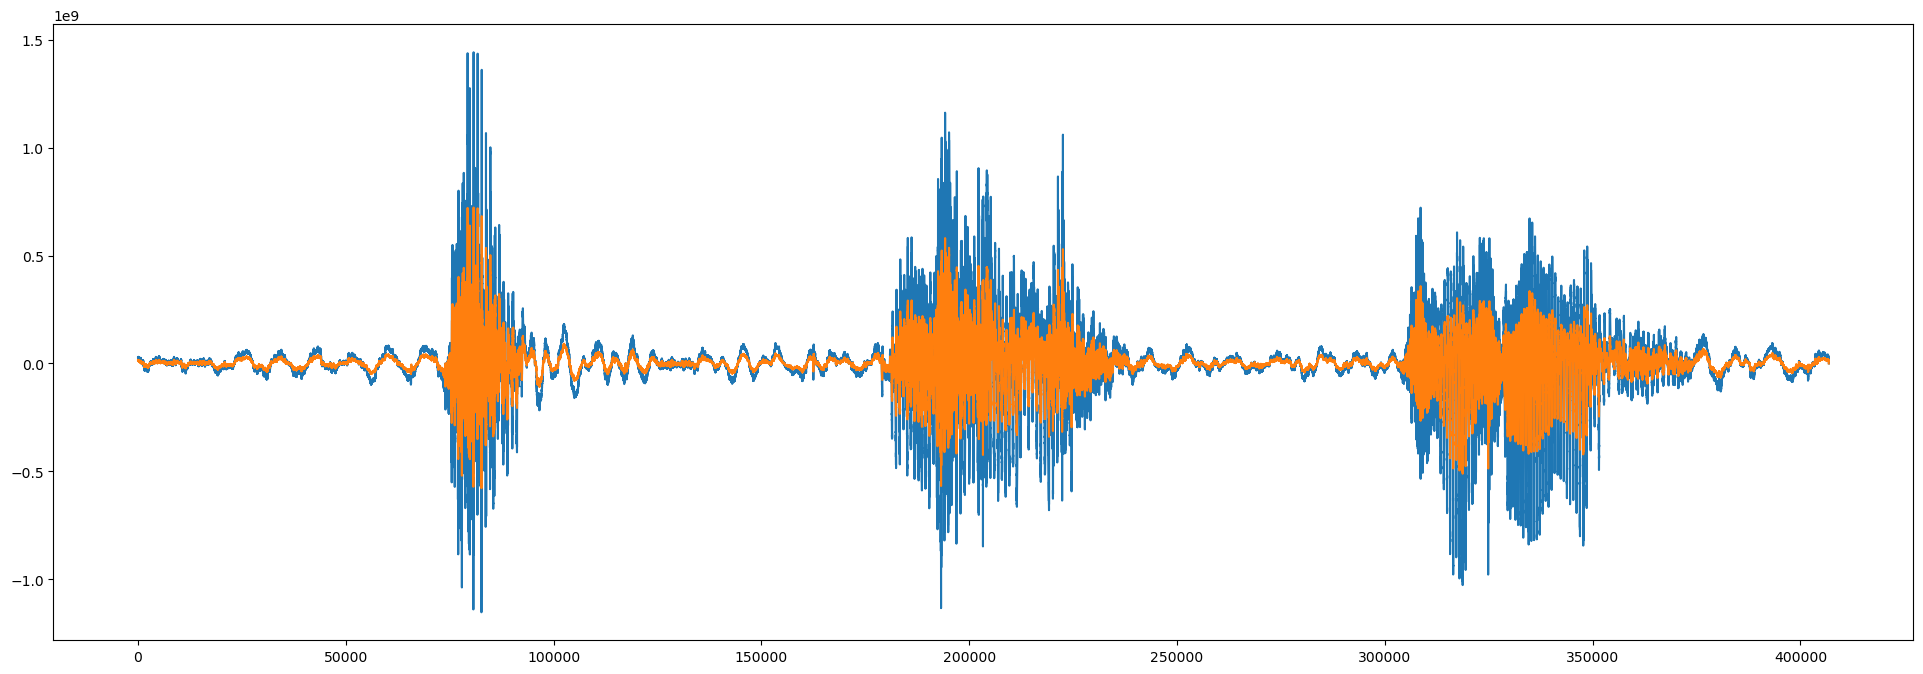

In [18]:
# 파형 그림 그리기

import matplotlib.pyplot as plt
def plot_waveform(audio_file1, audio_file2):
    # 오디오 파일 로드
    audio1 = AudioSegment.from_file(audio_file1)
    audio2 = AudioSegment.from_file(audio_file2)

    # 오디오 데이터 추출
    samples1 = audio1.get_array_of_samples()
    samples2 = audio2.get_array_of_samples()
    
    # 그래프 크기 조절
    plt.figure(figsize = (24,8))

    # 파형 그래프 생성
    plt.plot(samples2)
    plt.plot(samples1)
    

    # 그래프 표시
    plt.show()
    
plot_waveform('S#17 C#3 후시녹음.wav', 'S#17 C#3 후시녹음_output_audio_coordinates.wav')